In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
from sklearn.model_selection import train_test_split

In [2]:
base_dir = "datos"
fake_dir = os.path.join(base_dir, "fake")
real_dir = os.path.join(base_dir, "real")

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            img = Image.open(file_path).convert("RGB")  # Convertir a RGB
            img = img.resize((224, 224))  # Redimensionar a 224x224
            images.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error al cargar la imagen {file_path}: {e}")
    return images, labels

fake_images, fake_labels = load_images_from_folder(fake_dir, 0)  # 0 para 'fake'
real_images, real_labels = load_images_from_folder(real_dir, 1)  # 1 para 'real'


X = np.array(fake_images + real_images)
y = np.array(fake_labels + real_labels)


In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Dividir el restante (30%) en validación (50%) y prueba (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Confirmar las formas
print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
print("Prueba:", X_test.shape, y_test.shape)


Entrenamiento: (1919, 224, 224, 3) (1919,)
Validación: (240, 224, 224, 3) (240,)
Prueba: (240, 224, 224, 3) (240,)


In [4]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [5]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Promedio global de las características de la capa anterior
    layers.Dense(128, activation='relu'),  # Capa densa intermedia
    layers.Dropout(0.2),  # Regularización
    layers.Dense(1, activation='sigmoid')  # Capa de salida binaria
])

with tf.device('/GPU:0'):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
______________________________________

In [6]:

# Paso 5: Preprocesamiento de imágenes (usando ImageDataGenerator)
# train_datagen = ImageDataGenerator(rescale=1.0/255)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,          # Normalización
    rotation_range=20,        # Rotación aleatoria
    width_shift_range=0.2,    # Desplazamiento horizontal
    height_shift_range=0.2,   # Desplazamiento vertical
    zoom_range=0.2,           # Zoom aleatorio
    horizontal_flip=True      # Inversión horizontal
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Crear generadores para cada conjunto (esto asume que tienes los datos organizados en carpetas 'fake' y 'real')
train_generator = train_datagen.flow(
    X_train, y_train,  # X_train y y_train son tus datos y etiquetas de entrenamiento
    batch_size=32,
    shuffle=True
)

val_generator = val_test_datagen.flow(
    X_val, y_val,  # X_val y y_val son tus datos y etiquetas de validación
    batch_size=32
)

with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator
    )

Epoch 1/15
60/60 [==============================] - 23s 325ms/step - loss: 0.7370 - accuracy: 0.4940 - val_loss: 0.6952 - val_accuracy: 0.4958
Epoch 2/15
60/60 [==============================] - 23s 376ms/step - loss: 0.7126 - accuracy: 0.5029 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 3/15
60/60 [==============================] - 16s 271ms/step - loss: 0.7065 - accuracy: 0.5128 - val_loss: 0.6913 - val_accuracy: 0.5375
Epoch 4/15
60/60 [==============================] - 12s 200ms/step - loss: 0.6952 - accuracy: 0.5206 - val_loss: 0.6910 - val_accuracy: 0.4958
Epoch 5/15
60/60 [==============================] - 12s 200ms/step - loss: 0.6978 - accuracy: 0.5284 - val_loss: 0.6893 - val_accuracy: 0.5500
Epoch 6/15
60/60 [==============================] - 12s 202ms/step - loss: 0.6958 - accuracy: 0.5320 - val_loss: 0.6901 - val_accuracy: 0.5125
Epoch 7/15
60/60 [==============================] - 12s 203ms/step - loss: 0.6961 - accuracy: 0.5206 - val_loss: 0.6878 - val_accuracy: 0.5542

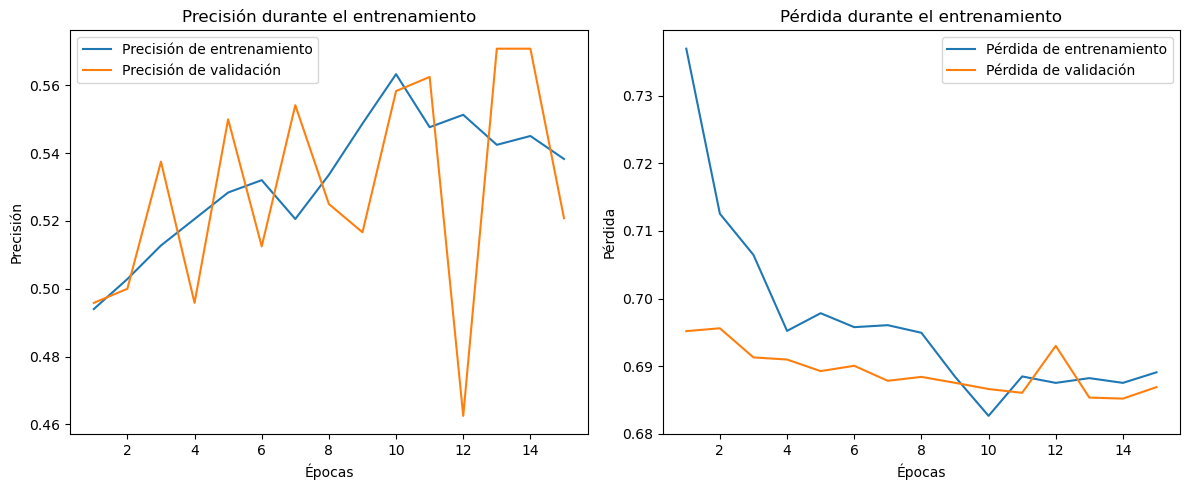

In [7]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()


8/8 [==============================] - 1s 25ms/step


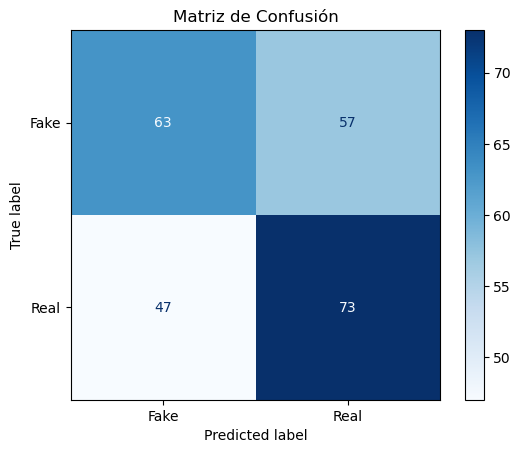

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generar predicciones en el conjunto de prueba
y_pred_prob = model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)  # Convertir probabilidades en etiquetas binarias

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()


In [9]:
# Calcular Accuracy
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy: {accuracy:.4f}")

# Calcular Recall para cada clase
recall_fake = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Para la clase 'Fake'
recall_real = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # Para la clase 'Real'

print(f"Recall (Fake): {recall_fake:.4f}")
print(f"Recall (Real): {recall_real:.4f}")

Accuracy: 0.5667
Recall (Fake): 0.5250
Recall (Real): 0.6083


1/1 [==============================] - 0s 18ms/step


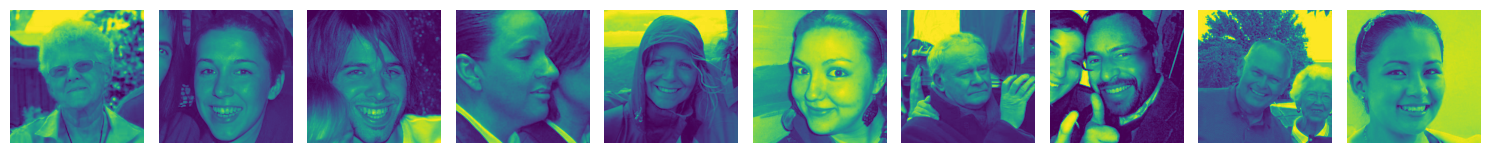

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model

# Crear un modelo intermedio que devuelva las activaciones de las capas
layer_outputs = [layer.output for layer in base_model.layers]
activation_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Seleccionamos 10 índices aleatorios de imágenes en el conjunto de entrenamiento
random_indices = np.random.choice(len(X_train), 10, replace=False)

# Configuramos el gráfico para mostrar 10 imágenes y sus activaciones
plt.figure(figsize=(15, 15))

# Iteramos sobre las imágenes seleccionadas aleatoriamente
for idx, image_index in enumerate(random_indices):
    # Escoge una imagen aleatoria de X_train
    image = X_train[image_index]

    # Preprocesar la imagen (la red espera imágenes de 224x224x3)
    image_input = np.expand_dims(image, axis=0)  # Convertir a un batch
    image_input = tf.keras.applications.resnet50.preprocess_input(image_input)

    # Obtener las activaciones
    activations = activation_model.predict(image_input)

    # Selecciona la activación de la primera capa convolucional (Conv1)
    first_layer_activation = activations[0]  # Activaciones de la primera capa (Conv1)

    # Visualizar la activación de la primera capa para esta imagen
    plt.subplot(10, 10, idx + 1)
    plt.imshow(first_layer_activation[0, :, :, 0], cmap='viridis')  # Muestra el primer filtro
    plt.axis('off')

plt.tight_layout()
plt.show()



In [26]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4117832..0.5701465].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.048617333..0.0546955].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021725226..0.03330306].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0611656..0.22425501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32653672..0.4524633].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40460095..0.23130278].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [

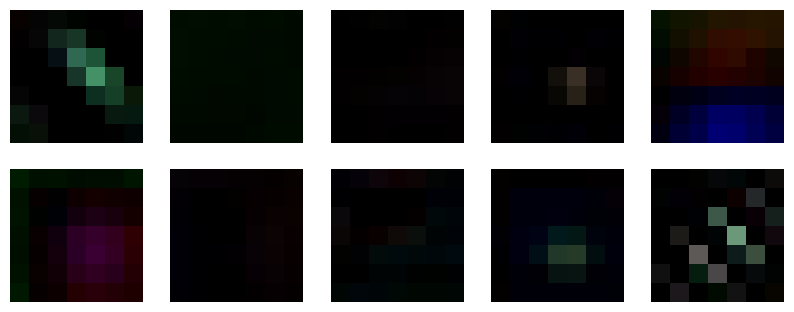

In [31]:
# Ver los filtros de la primera capa convolucional
filters = base_model.get_layer('conv1_conv').get_weights()[0]

# Visualizar algunos de los filtros (en este caso, 10 filtros)
plt.figure(figsize=(10, 10))
for i in range(10):  # Mostrar 10 filtros
    plt.subplot(5, 5, i + 1)
    plt.imshow(filters[:, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()



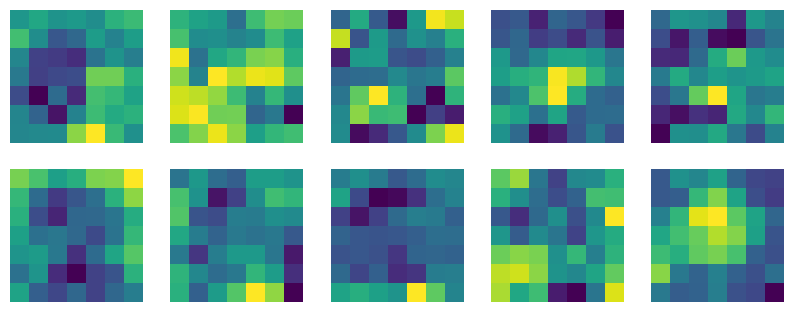

In [44]:
# Ver activaciones de una capa más profunda
deep_layer_activation = activations[150]  # Escoge la capa que desees

# Visualizar las activaciones de la capa profunda
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(deep_layer_activation[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()
